# Mini-Project 4

Welcome to your fourth Mini Project! You will build an LSTM models to classify text and for anomaly detection (also outlier detection) on the temperature sensor data. **Please complete your assignment in this Jupyter Notebook.**

---

**Requirements**: 
- Pytorch is allowed to implement your models.
- Your code should follow [PEP 8](https://www.python.org/dev/peps/pep-0008/) with necessary comments.

Preliminaries

In [1]:
# libraries
from google.colab import drive
import pandas as pd
import re
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
!pip install pytorch-nlp
from torchnlp.encoders.text import WhitespaceEncoder
from torchnlp.encoders.text import stack_and_pad_tensors
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
!pip install torchviz
from torchviz import make_dot

# settings
drive.mount("/content/drive") # mount the drive
path = "/content/drive/My Drive/Coursework/Deep Learning/Mini Project 04/" # path to dataset directory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Task 1: Text Classification

This task aims to train a sentiment analysis model to classify given sentences as **positive or negative**, based on the Recurrent Neural Network.

---

**Tasks**

1. Explore data
    - Load the training data and the test data.
    - Extract labels and texts which are seperated by the string of `" +++$+++ "`.
    - Eliminate index information in the test data so that you can get pure sentences.
    - Print out the first 10 examples of your training set and test set.
2. Preprocess data
    - Tokenize the data and convert the text to sequences.
    - Add padding to ensure that all the sequences have the same shape.
    - **Hint**: click [here](https://github.com/PetrochukM/PyTorch-NLP) for more information.
3. Prepare your data for training and testing with DataLoaders
    - Use the preprocesed data to create the [Custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) 
    - Prepare your data for training with [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders)
3. Build LSTM model
    - Build a LSTM based on Pytorch.
    - Visualize the model using [PyTorchViz](https://github.com/szagoruyko/pytorchviz).
    - **Hint**: click [here](https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/) for more information.
4. Train model
    - Initialize hyperparameters.
    - Train your model.
    - Visualize the performance including training loss, training accuracy, validation loss, and validation accuracy.
5. Predict
    - Test your model on the test data.
    - Save the predicted results (labels and texts) in a CSV file and submit it to Canvas.


Explore Data

In [2]:
# load training data
temp_data  = [] # list for storing temporary data
train_data = [] # list for storing training data features (texts)
label_data = [] # list for storing training data labels
with open(path + "Task1_Training_Data.txt", 'r') as train_file: # open training data text file
    for line in train_file: # go through each line
        strip = line.strip().split(' +++$+++ ') # extract labels and texts which are seperated by the string of " +++$+++ "
        temp_data.append(strip) # append data to list
for sample in temp_data: # go thorough each sample
    text  = sample[-1] # feature (text)
    label = sample[0] # label
    train_data.append(text) # append data to list
    label_data.append(int(label)) # append data to list
print('First 10 Examples of Train Data: ', train_data[0:10]) # print out first 10 examples of train data
print('\nFirst 10 Examples of Train Labels: ', label_data[0:10]) # print out first 10 examples of train labels

# load testing data
test_data = [] # list for storing testing data
with open(path + "Task1_Testing_Data.txt", 'r') as test_file: # open testing data text file
    for line in test_file: # go through each line
        strip = line.strip() # strip (remove white-spaces from start and end of) the line
        pure = re.split('(\d+,)', strip)[-1] # eliminate index information to get pure sentences
        test_data.append(pure) # append data to list
test_data = test_data[1:] # slice data from 1 to end to remove headers
print('\nFirst 10 Examples of Test Data: ', test_data[0:10]) # print out first 10 examples of test data

First 10 Examples of Train Data:  ['are wtf ... awww thanks !', 'leavingg to wait for kaysie to arrive myspacin itt for now ilmmthek .!', 'i wish i could go and see duffy when she comes to mamaia romania .', "i know eep ! i can ' t wait for one more day ....", 'so scared and feeling sick . fuck ! hope someone at hr help ... wish it would be wendita or karen .', 'my b day was thurs . i wanted 2 do 5 this weekend for my b day but i guess close enough next weekend . going alone', 'e3 is in the trending topics only just noticed ive been tweeting on my iphone until now', 'where did you get him from i know someone who would love that !', 'dam just got buzzed by another huge fly ! this time it landed on my head ... not impressed', "tomorrowwwwwwwww !!! you ' ll love tomorrow ' s news !"]

First 10 Examples of Train Labels:  [1, 1, 0, 1, 0, 0, 1, 1, 0, 1]

First 10 Examples of Test Data:  ['my dog ate our dinner . no , seriously ... he ate it .', 'omg last day sooon n of primary noooooo x im g

Preprocess Data

In [3]:
# training text (features) 
text_encoder = WhitespaceEncoder(train_data) # tokenizer and encoder for training text (features)
text_encoded_data = [text_encoder.encode(example) for example in train_data] # tokenize and encode training text (features)
text_padded_data = stack_and_pad_tensors(text_encoded_data)[0] # add padding to training text (features)

# training labels
label_data = torch.from_numpy(np.array(label_data)) # prepare training labels

# testing text (features)
test_encoder = WhitespaceEncoder(test_data) # tokenizer and encoder for testing text (features)
test_encoded_data = [test_encoder.encode(example) for example in test_data] # tokenize and encode testing text (features)
test_padded_data = stack_and_pad_tensors(test_encoded_data)[0] # add padding to testing text (features)

In [4]:
# verify shapes of train and test data
print('Train Features Shape : ', text_padded_data.shape)
print('Train Labels Shape   : ', label_data.shape)
print('Test Data Shape      : ', test_padded_data.shape)

Train Features Shape :  torch.Size([200000, 39])
Train Labels Shape   :  torch.Size([200000])
Test Data Shape      :  torch.Size([200000, 39])


Prepare Data for Training and Validation

In [5]:
# create custom dataset
class Create_Data(Dataset): # create pytorch compatible data
    def __init__(self, data, target, transform=None):
        self.data = data # define data (features)
        self.target = target # define targets (labels)
        self.transform = transform # define transform
    def __getitem__(self, index):
        x = self.data[index] # feature
        y = self.target[index] # label
        if self.transform:
            x = self.transform(x) # apply transform
        return x, y
    def __len__(self):
        return len(self.data) # dataset size

train_size  = 0.8 # split data into 80% train and 20% valid sets
num_workers = 2 # number of sub-processes to use for data loading
batch_size  = 64 # batch size

# split features into training set and valid set
X_train, X_valid = torch.utils.data.random_split(text_padded_data,
                                                 [train_size, 1-train_size],
                                                 generator=torch.Generator().manual_seed(36))
# split labels into training set and valid set
y_train, y_valid = torch.utils.data.random_split(label_data,
                                                 [train_size, 1-train_size],
                                                 generator=torch.Generator().manual_seed(36))
# store test set
X_test, y_test = test_padded_data, torch.tensor([0]*len(test_padded_data))

# training dataset
train_dataset = Create_Data(X_train, y_train) # training dataset
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available()) # training dataset loader
# validation dataset
valid_dataset = Create_Data(X_valid, y_valid) # validation dataset
valid_loader = DataLoader(valid_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available()) # validation dataset loader

# testing dataset
test_dataset = Create_Data(X_test, y_test) # testing dataset
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=num_workers,
                         pin_memory=torch.cuda.is_available()) # testing dataset loader

In [6]:
# verify lengths of train and valid loaders
print('Train Loader Length : ', len(train_loader.dataset))
print('Valid Loader Length : ', len(valid_loader.dataset))
print('Test Loader Length  : ', len(test_loader.dataset))

Train Loader Length :  160001
Valid Loader Length :  39999
Test Loader Length  :  200000


Build LSTM Model

In [7]:
# build the model
class Task1_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_dim, output_dim):
        super(Task1_LSTM, self).__init__()
        self.num_layers = num_layers # number of LSTM layers
        self.hidden_dim = hidden_dim # hidden dimension (LSTM output)
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # embedding
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True) # LSTM
        self.dropout1 = nn.Dropout(0.2) # droupout 1
        self.pooling = nn.AdaptiveAvgPool1d(1) # pooling
        self.dropout2 = nn.Dropout(0.1) # droupout 2
        self.fc1 = nn.Linear(hidden_dim, 64) # fully connected 1
        self.relu = nn.ReLU() # ReLU activation
        self.fc2 = nn.Linear(64, output_dim) # fully connected 2
        self.sigmoid = nn.Sigmoid() # Sigmoid activation

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_dim).to(device) # hidden state
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_dim).to(device) # cell state
        x = self.embedding(x) # embedding
        x, _ = self.lstm(x, (h0, c0)) # LSTM
        x = self.dropout1(x) # droupout 1
        x = x.permute(0, 2, 1) # permute dimensions
        x = self.pooling(x) # pooling
        x = x.squeeze(-1) # squeeze dimensions
        x = self.dropout2(x) # droupout 2
        x = self.fc1(x) # fully connected 1
        x = self.relu(x) # ReLU activation
        x = self.fc2(x) # fully connected 2
        x = self.sigmoid(x) # Sigmoid activation
        return x.squeeze(1) # squeeze dimensions

In [8]:
# initialize hyperparameters
vocab_size = text_encoder.vocab_size # vocabulary size
embedding_dim = 100 # embedding dimension
num_layers = 1 # number of LSTM layers
hidden_dim = 128 # hidden dimension (LSTM output)
output_dim = 1 # output dimensions
criterion = nn.BCEWithLogitsLoss() # loss function
learning_rate = 0.001 # learning rate
num_epochs = 9 # number of epochs

Task1_LSTM(
  (embedding): Embedding(82950, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


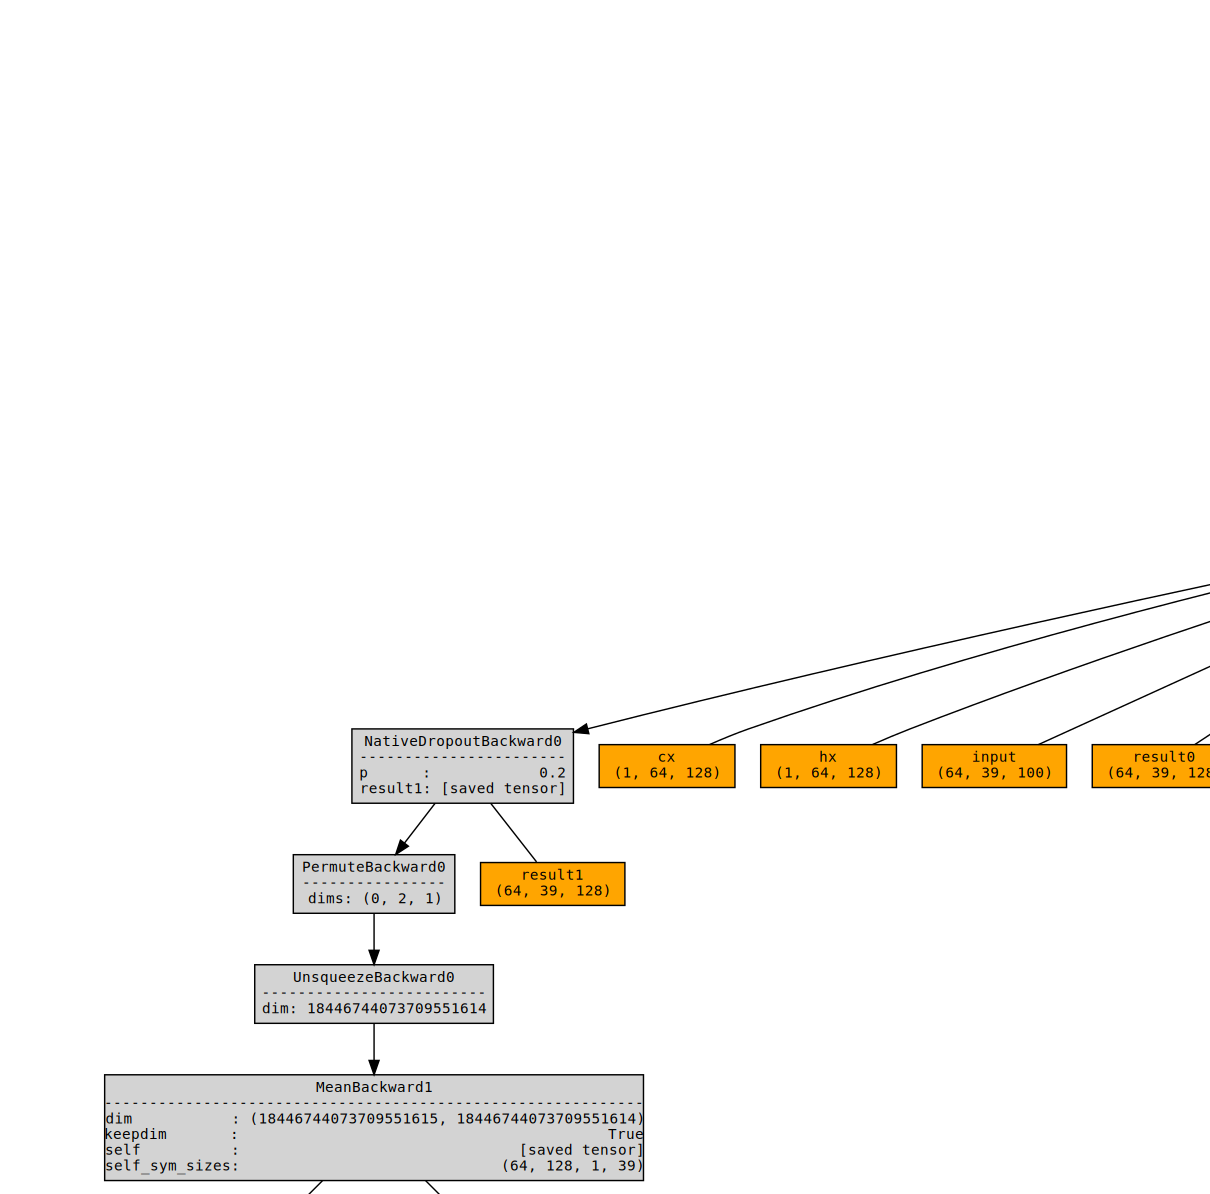

In [9]:
# visualize the model
for batch in train_loader: # extract batched training data
    x, y = batch
    break
x = x.to(device) # input
task1_model = Task1_LSTM(vocab_size=vocab_size, embedding_dim=embedding_dim, num_layers=num_layers,
                         hidden_dim=hidden_dim, output_dim=output_dim).to(device) # model object
print(task1_model) # print the model
y = task1_model(x) # output
dot = make_dot(y, params=dict(task1_model.named_parameters()), show_attrs=True, show_saved=True) # create model visualization
dot.format = "pdf" # model visualization saving format
dot.render(path + "Task1_Model") # save model visualization
dot # visualize model

Train the Model

In [10]:
# train and validate the model
optimizer = torch.optim.Adam(task1_model.parameters(), lr=learning_rate) # optimizer
train_loss_hist = [] # training loss history
valid_loss_hist = [] # validation loss history
train_acc_hist = [] # training accuracy history
valid_acc_hist = [] # validation accuracy history

print("Started Training!\n\n") # begin training

for epoch in range(num_epochs): # epochs

    # model training stage
    train_loss = 0.0 # training loss
    correct_preds = 0 # correct predictions
    total_preds = 0 # total predictions
    task1_model.train() # set model to training mode
    for train_inputs, train_labels in train_loader: # training data
        train_inputs = train_inputs.to(device) # load inputs to device
        train_labels = train_labels.to(device) # load labels to device
        optimizer.zero_grad() # reset gradient
        train_outputs = task1_model(train_inputs) # forward propagation
        loss = criterion(train_outputs, train_labels.float()) # loss computation
        loss.backward() # backward propagation
        optimizer.step() # parameter updates
        # training accuracy
        preds = (train_outputs > 0.5).long() # model predictions
        correct_preds += (preds == train_labels).sum().item() # correct predictions
        total_preds += len(train_labels) # total predictions
        train_loss += loss.item() # training loss
    train_loss /= len(train_loader) # average (mean) loss
    train_accuracy = correct_preds/total_preds # accuracy
    train_loss_hist.append(train_loss) # training loss history
    train_acc_hist.append(train_accuracy) # training accuracy history

    # model validation stage
    task1_model.eval() # set model to evaluation mode
    with torch.no_grad(): # turn off gradient calculation for optimized performance
        valid_loss = 0.0 # validation loss
        valid_correct_preds = 0 # correct predictions
        valid_total_preds = 0 # total predictions
        for valid_inputs, valid_labels in valid_loader: # validation data
            valid_inputs = valid_inputs.to(device) # load inputs to device
            valid_labels = valid_labels.to(device) # load labels to device
            valid_outputs = task1_model(valid_inputs) # forward propagation
            valid_loss += criterion(valid_outputs, valid_labels.float()).item() # loss computation
            # validation accuracy
            valid_preds = (valid_outputs > 0.5).long() # model predictions
            valid_correct_preds += (valid_preds == valid_labels).sum().item() # correct predictions
            valid_total_preds += len(valid_labels) # total predictions
        valid_loss /= len(valid_loader) # average (mean) loss
        valid_accuracy = valid_correct_preds/valid_total_preds # accuracy
        valid_loss_hist.append(valid_loss) # validation loss history
        valid_acc_hist.append(valid_accuracy) # validation accuracy history
    
    # print training & validation stats at end of each epoch
    print("Epoch: {}    Train Loss: {:.4f}    Train Accuracy: {:.4f}    Valid Loss: {:.4f}    Valid Accuracy: {:.4f}".format(
          epoch+1, train_loss, train_accuracy, valid_loss, valid_accuracy))

print("\n\nFinished Training!") # finish training

Started Training!


Epoch: 1    Train Loss: 0.6446    Train Accuracy: 0.6626    Valid Loss: 0.6162    Valid Accuracy: 0.7543
Epoch: 2    Train Loss: 0.6047    Train Accuracy: 0.7683    Valid Loss: 0.6073    Valid Accuracy: 0.7654
Epoch: 3    Train Loss: 0.5930    Train Accuracy: 0.7956    Valid Loss: 0.6034    Valid Accuracy: 0.7724
Epoch: 4    Train Loss: 0.5860    Train Accuracy: 0.8120    Valid Loss: 0.6024    Valid Accuracy: 0.7813
Epoch: 5    Train Loss: 0.5799    Train Accuracy: 0.8260    Valid Loss: 0.6012    Valid Accuracy: 0.7832
Epoch: 6    Train Loss: 0.5762    Train Accuracy: 0.8351    Valid Loss: 0.6010    Valid Accuracy: 0.7798
Epoch: 7    Train Loss: 0.5726    Train Accuracy: 0.8430    Valid Loss: 0.6010    Valid Accuracy: 0.7822
Epoch: 8    Train Loss: 0.5692    Train Accuracy: 0.8508    Valid Loss: 0.6011    Valid Accuracy: 0.7897
Epoch: 9    Train Loss: 0.5669    Train Accuracy: 0.8556    Valid Loss: 0.6023    Valid Accuracy: 0.7821


Finished Training!


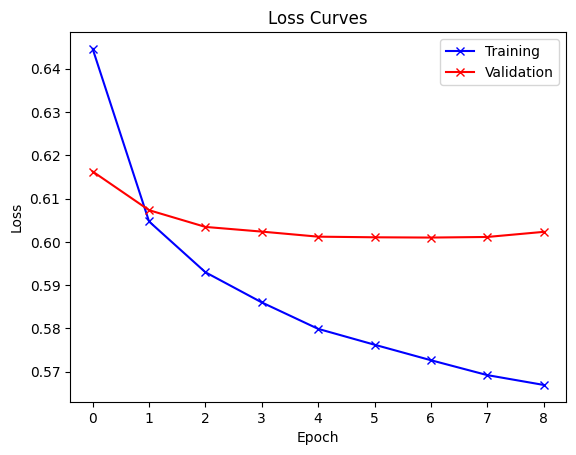

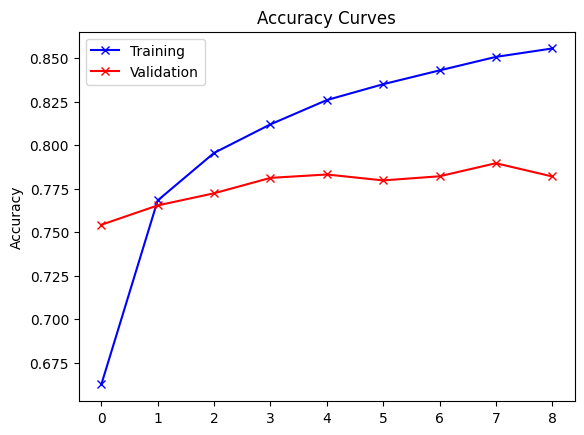

In [11]:
# plot the history of losses in each epoch
plt.plot(train_loss_hist, '-bx', label='Training') # plot training loss
plt.plot(valid_loss_hist, '-rx', label='Validation') # plot validation loss
plt.xlabel('Epoch') # label for x-axis
plt.ylabel('Loss') # label for y-axis
plt.legend() # legend
plt.title('Loss Curves') # title 
plt.show() # show plot

# plot the history of accuracies in each epoch
plt.plot(train_acc_hist, '-bx', label='Training')  # plot training accuracy
plt.plot(valid_acc_hist, '-rx', label='Validation') # plot validation accuracy
plt.ylabel('Accuracy') # label for y-axis
plt.legend() # legend
plt.title('Accuracy Curves') # title 
plt.show() # show plot

Predict using the Model

In [12]:
# get model predictions
task1_model.eval()  # set model to evaluation mode
with torch.no_grad(): # turn off gradient calculation for optimized performance
    test_preds = [] # testing predictions
    for test_inputs, _ in test_loader:
        test_inputs = test_inputs.to(device) # load inputs to device
        test_outputs = task1_model(test_inputs) # forward propagation
        test_preds_batch = (test_outputs > 0.5).long()
         # batch predictions
        test_preds.extend(test_preds_batch) # extend (concatenate) batch predictions

# print first 10 predictions
for i in range(10):
    print(str(test_preds[i].cpu().numpy()) + ' <-- ' + test_data[i].strip('"'))

# combine model predicted labels and input text features
test_results = []
for i in range(len(test_data)):
    pred_str = str(test_preds[i].cpu().numpy()) # convert predictions to string
    text_str = test_data[i].strip('"') # remove inverted commas from the text
    text_str = re.sub(",", "", text_str) # remove commas from the text
    test_results.append(pred_str + ',' + text_str + '\n') # append to list

# write to csv file (commas within sentences are removed to avoid breaks in csv file)
with open(path + 'Task1_Results.csv', 'w') as file: # open file
    for result in test_results: # iterate over individual predictions
        file.write(result) # write to file

1 <-- my dog ate our dinner . no , seriously ... he ate it .
1 <-- omg last day sooon n of primary noooooo x im gona be swimming out of school wif the amount of tears am gona cry
0 <-- stupid boys .. they ' re so .. stupid !
0 <-- hi ! do u know if the nurburgring is open for tourists today ? we want to go , but there is an event today
0 <-- having lunch in the office , and thinking of how to resolve this discount form issue
1 <-- shopping was fun
0 <-- wondering where all the nice weather has gone .
1 <-- morning ! yeeessssssss new mimi in aug
0 <-- umm ... maybe that ' s how the british spell it ?
0 <-- yes it ' s 3 : 50 am . yes i ' m still awake . yes i can ' t sleep . yes i ' ll regret it tomorrow . haha i love you mr saturday


## Task 2: Anomaly Detection

In manufacturing industries, the anomaly detection technique is applied to predict the abnormal activities of machines based on the data read from sensors. In machine learning and data mining, anomaly detection is the task of identifying the rare items, events, or observations that are suspicious and seem different from the majority of the data. In this task, you will predict the possible failure of the system based on the temperature data. And this failure can be detected by check if they follow the trend of the majority of the data.

---

**Dataset**

The given dataset (`Task2_Data.csv`) is a part of Numenta Anomaly Benchmark (NAB) dataset, which is a novel benchmark for evaluating machine learning algorithms in anomaly detection.

**Tasks**

Because the labels have not been given, you will need to use a LSTM based model to capture the trend of the feature for majority of the data. First, extract $n_x$ features from each of the raw data point. Second, create a sliding window with length $l$. Third, fomulate LSTM taking a matrix of shape $l \times n_x$ as the input to predict the temperature value of the next time step $l+1$. Last, compare the predicted result and the real data and find out abnormal points where the difference between these two values are larger than the threshold. 

For instance, if we want to extract 3 features ($n_x=3$), and set the sliding window length to 100 ($l=100$). Then LSTM will take the first 100 (e.g., $[0:100]$) time step data as the input to predict the temperature value of the next time step (e.g., 101). The shape of the input will be $100 \times 3$, and shape of the output will be a single number.

1. Load data
    - Read the CSV file.
    - Draw a curve to visualize the time-series data.
2. Preprocess data
    - The raw data of temperature is the degree Fahrenheit, you will need to convert it into degree Celcius.
    - Use Pandas package convert string timestamp data into the datetime data. Click [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html) for details.
3. Feature Engineering
    - We will use datetime data to generate four features: hours, day or night, day of the week, weekday or weekends.
    - Hour: convert datetime data into hours. The result of your processed data will be [0, 1, 2, ..., 22, 23, 0, 1, ..., 22, 23]. Check [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.hour.html).
    - Day or night: this will be a binary data. 7:00-22:00 will be day time, the rest will be night.
    - Day of the week: convert datetime data into day of the week. The result of your processed data will be [0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6 ...]. Click [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.dayofweek.html) for more information.
    - Workday or weekend: this will be a binary data. Monday to Friday will be workdays, Saturday and Sunday are weekend.
    
4. Prepare training and testing dataloaders
    - Split the dataset into training set and test set.
    - Min-max normalization.
    - Generate sliding window (similar to the last task of HW1) data.
    - Use the preprocessed data to create the [Custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial).
    - Prepare your data for training and testing with [DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders).
3. Build LSTM model
    - Build an LSTM model using Pytorch.
    - Visualize your model.
4. Train model
    - Initialize hyperparameters.
    - Train the model.
    - Evaluate the trained model on the test data.
    - Visualize the performance including training loss and test loss.
5. Find anomalies
    - Specify the threshold and predict anomalies on testing dataset.
    - Visualize the anomalies.


Load Data

In [13]:
df = pd.read_csv(path + 'Task2_Data.csv') # read csv file and create dataframe
fig = px.line(df, x='timestamp', y='value') # plot timeseries data
fig.update_layout(title='Timeseries Data',
                  xaxis_title='Timestamp',
                  yaxis_title='Temperature (°F)') # update plot layout
fig.show() # show plot
df.head() # print dataframe head

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


Preprocess Data

In [14]:
df['value'] = (df['value']-32)*5/9 # convert °F to °C
df['timestamp'] = pd.to_datetime(df['timestamp']) # convert string timestamp to datetime
fig = px.line(df, x='timestamp', y='value') # plot timeseries data
fig.update_layout(title='Timeseries Data',
                  xaxis_title='Timestamp',
                  yaxis_title='Temperature (°C)') # update plot layout
fig.show() # show plot
df.head() # print dataframe head

,timestamp,value
0,2013-07-04 00:00:00,21.044908
1,2013-07-04 01:00:00,21.789015
2,2013-07-04 02:00:00,21.598781
3,2013-07-04 03:00:00,20.533000
4,2013-07-04 04:00:00,20.713084


Feature Engineering

In [15]:
df['hours'] = df['timestamp'].dt.hour # extract hours (hr)
df['shift'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int) # extract shift (0=night, 1=day)
df['dayofweek'] = df['timestamp'].dt.dayofweek # extract day of the week (0=Mon, 1=Tue, ..., 6=Sun)
df['weekday'] = (df['dayofweek'] < 5).astype(int) # extract day (0=weekend, 1=weekday)
df.head() # print dataframe head

,timestamp,value,hours,shift,dayofweek,weekday
0,2013-07-04 00:00:00,21.044908,0,0,3,1
1,2013-07-04 01:00:00,21.789015,1,0,3,1
2,2013-07-04 02:00:00,21.598781,2,0,3,1
3,2013-07-04 03:00:00,20.533000,3,0,3,1
4,2013-07-04 04:00:00,20.713084,4,0,3,1


Training & Testing Dataloaders

In [16]:
# concatenate all data
data = df[['value', 'hours', 'shift', 'dayofweek', 'weekday']]

# perform min-max normalization
scaler = MinMaxScaler() # initialize min-max scaler
scaler.fit(data[['value', 'hours', 'shift', 'dayofweek', 'weekday']]) # fit data
data[['value', 'hours', 'shift', 'dayofweek', 'weekday']] = scaler.transform(data) # transform data
data.head() # print dataframe head

<ipython-input-16-3a58ca7a5b59>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,value,hours,shift,dayofweek,weekday
0,0.431862,0.000000,0.0,0.5,1.0
1,0.478426,0.043478,0.0,0.5,1.0
2,0.466521,0.086957,0.0,0.5,1.0
3,0.399829,0.130435,0.0,0.5,1.0
4,0.411098,0.173913,0.0,0.5,1.0


In [17]:
# split data into train and valid sets
test_size = (0.2*len(data)) # split data into 80% train and 20% valid sets
pred_time = 1 # prediction time horizon
nx = 5 # number of features (value, hours, shift, dayofweek, weekday)
l = 250 # (use 250 samples to predict value of 251st sample using sliding window approach)
test_cut = int(test_size + l + 1) # train-test split index

# training dataset
X_train = data[0:-pred_time-test_cut].values # training features
y_train = data[pred_time:-test_cut]['value'].values # training labels

# testing dataset
X_valid = data[0-test_cut:-pred_time].values # testing features
y_valid = data[pred_time-test_cut:]['value'].values # testing labels

# generate sliding window
def sliding_window(data, sequence_length=l):
    result = []
    for index in range(len(data)-sequence_length):
        result.append(data[index:index+sequence_length])
    return np.asarray(result)

# prepare data
X_train = sliding_window(X_train, l) # training features
y_train = y_train[-X_train.shape[0]:] # training labels
X_valid = sliding_window(X_valid, l) # testing features
y_valid  = y_valid[-X_valid.shape[0]:] # testing labels

In [18]:
# verify shapes of train and valid sets
print('Train Data Shape: ', X_train.shape)
print('Valid Data Shape: ', X_valid.shape)

Train Data Shape:  (5312, 250, 5)
Valid Data Shape:  (1453, 250, 5)


In [19]:
# create custom dataset
class Create_Data(Dataset): # create pytorch compatible data
    def __init__(self, data, target, transform=None):
        self.data = data # define data (features)
        self.target = target # define targets (labels)
        self.transform = transform # define transform
    def __getitem__(self, index):
        x = self.data[index] # feature
        y = self.target[index] # label
        if self.transform:
            x = self.transform(x) # apply transform
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.data) # dataset size

num_workers = 2 # number of sub-processes to use for data loading
batch_size  = 64 # batch size

# training dataset
train_data = Create_Data(X_train, y_train) # training dataset
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available()) # training dataset loader

# validation dataset
valid_data = Create_Data(X_valid, y_valid) # validation dataset
valid_loader = DataLoader(valid_data,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=torch.cuda.is_available()) # validation dataset loader

Build LSTM Model

In [20]:
# build the model
class Task2_LSTM(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(Task2_LSTM, self).__init__()
        self.num_layers = num_layers # number of LSTM layers
        self.hidden_size = hidden_size # hidden dimension (LSTM output)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) # LSTM
        self.dropout = nn.Dropout(0.2) # dropout
        self.linear = nn.Linear(hidden_size, output_size) # fully connected
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device) # hidden state
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device) # cell state
        x, _ = self.lstm(x, (h0, c0)) # LSTM
        x = self.dropout(x[:, -1, :]) # dropout
        x = self.linear(x) # fully connected
        return x

In [21]:
# initialize hyperparameters
input_size = nx # input dimensions (number of features = nx = 5)
num_layers = 1 # number of LSTM layers
hidden_size = 128 # hidden dimension (LSTM output)
output_size = 1 # output dimensions
criterion = nn.MSELoss() # loss function
learning_rate = 0.0005 # learning rate
num_epochs = 9 # number of epochs

Task2_LSTM(
  (lstm): LSTM(5, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


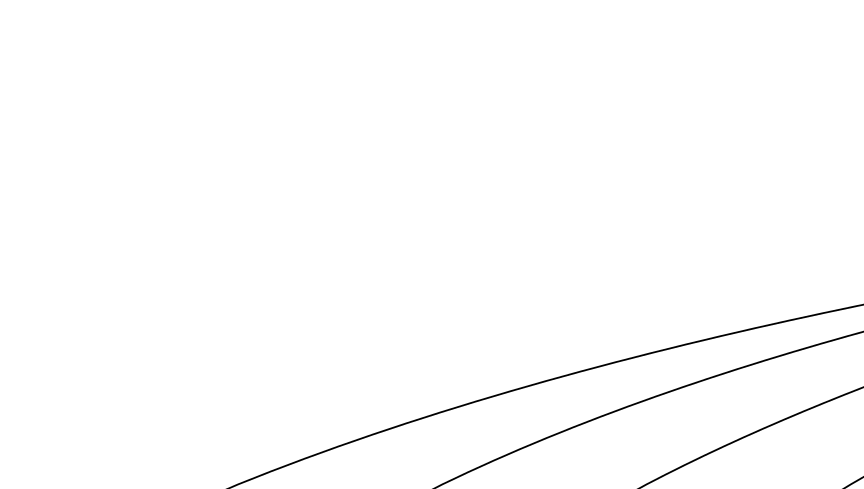

In [22]:
# visualize the model
for batch in train_loader: # extract batched training data
    x, y = batch
    break
x = x.to(device) # input
task2_model = Task2_LSTM(input_size=input_size, num_layers=num_layers,
                         hidden_size=hidden_size, output_size=output_size).to(device) # model object
print(task2_model) # print the model
y = task2_model(x) # output
dot = make_dot(y, params=dict(task2_model.named_parameters()), show_attrs=True, show_saved=True) # create model visualization
dot.format = "pdf" # model visualization saving format
dot.render(path + "Task2_Model") # save model visualization
dot # visualize model

Train the Model

In [23]:
# train and validate the model
optimizer = optim.Adam(task2_model.parameters(), lr=learning_rate) # optimizer
train_loss_hist = [] # training loss history
valid_loss_hist = [] # validation loss history

print("Started Training!\n\n") # begin training

for epoch in range(num_epochs): # epochs
    train_loss = 0.0 # training loss
    correct_preds = 0 # correct predictions
    total_preds = 0 # total predictions
    task2_model.train() # set model to training mode

    # model training stage
    for train_inputs, train_labels in train_loader: # training data
        train_inputs = train_inputs.to(device) # load features to device
        train_labels = train_labels.to(device) # load labels to device
        optimizer.zero_grad() # reset gradient
        train_outputs = task2_model(train_inputs) # forward propagation
        loss = criterion(train_outputs.squeeze(), train_labels) # loss computation
        loss.backward() # backward propagation
        optimizer.step() # parameter updates
        train_loss += loss.item()*train_inputs.size(0) # training loss
    train_loss /= len(train_loader.dataset) # average (mean) loss
    train_loss_hist.append(train_loss) # training loss history

    # Evaluate on validation dataset
    task2_model.eval() # set model to evaluation mode
    with torch.no_grad(): # turn off gradient calculation for optimized performance
        valid_loss = 0.0 # validation loss
        for valid_inputs, valid_labels in valid_loader: # validation data
            valid_inputs = valid_inputs.to(device) # load features to device
            valid_labels = valid_labels.to(device) # load labels to device
            valid_outputs = task2_model(valid_inputs) # forward propagation
            val_loss = criterion(valid_outputs.squeeze(), valid_labels) # loss computation
            valid_loss += val_loss.item()*valid_inputs.size(0) # validation loss
        valid_loss /= len(valid_loader.dataset) # average (mean) loss
        valid_loss_hist.append(valid_loss) # validation loss history
    # print training & validation stats at end of each epoch
    print("Epoch: {}    Train Loss: {:.4f}    Valid Loss: {:.4f}".format(
          epoch+1, train_loss, valid_loss))

print("\n\nFinished Training!") # finish training

Started Training!


Epoch: 1    Train Loss: 0.0344    Valid Loss: 0.0410
Epoch: 2    Train Loss: 0.0073    Valid Loss: 0.0118
Epoch: 3    Train Loss: 0.0033    Valid Loss: 0.0077
Epoch: 4    Train Loss: 0.0027    Valid Loss: 0.0059
Epoch: 5    Train Loss: 0.0025    Valid Loss: 0.0053
Epoch: 6    Train Loss: 0.0024    Valid Loss: 0.0047
Epoch: 7    Train Loss: 0.0023    Valid Loss: 0.0052
Epoch: 8    Train Loss: 0.0021    Valid Loss: 0.0044
Epoch: 9    Train Loss: 0.0021    Valid Loss: 0.0055


Finished Training!


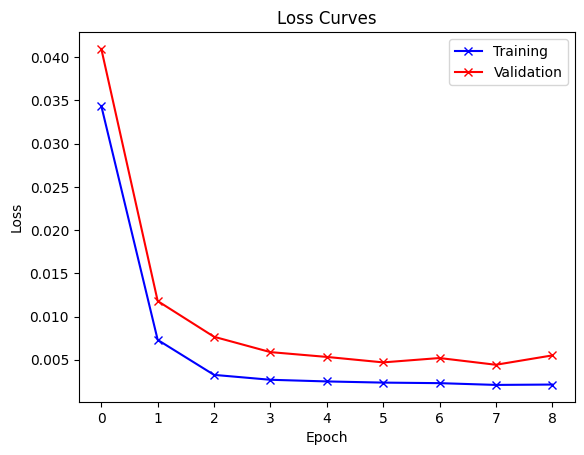

In [24]:
# plot the history of losses in each epoch
plt.plot(train_loss_hist, '-bx', label='Training') # plot training loss
plt.plot(valid_loss_hist, '-rx', label='Validation') # plot validation loss
plt.xlabel('Epoch') # label for x-axis
plt.ylabel('Loss') # label for y-axis
plt.legend() # legend
plt.title('Loss Curves') # title 
plt.show() # show plot

Find Anomalies

Evaluation Loss: 0.0248
Anomalies Detected: 713


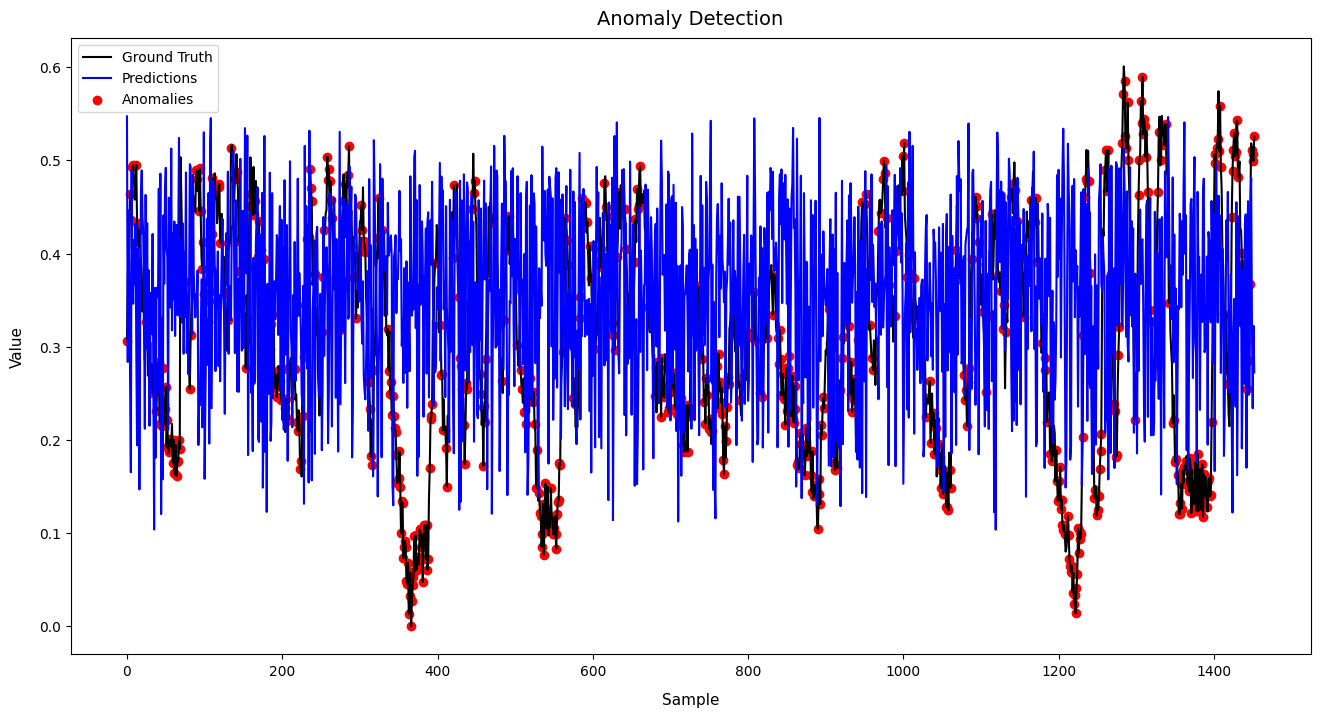

In [25]:
# get model predictions
task2_model.eval() # set model to evaluation mode
with torch.no_grad(): # turn off gradient calculation for optimized performance
    predictions = [] # predictions
    for inputs, _ in valid_loader:
        inputs = inputs.to(device) # load inputs to device
        outputs = task2_model(inputs) # forward propagation
        predictions.append(outputs.cpu().numpy()) # batch predictions
predictions = np.concatenate(predictions) # concatenate batch predictions

# model evaluation
eval_loss = criterion(torch.tensor(predictions.squeeze(), dtype=torch.float32),
                      torch.tensor(y_valid, dtype=torch.float32)).item()
print("Evaluation Loss: {:.4f}".format(eval_loss))

# differences between model predictions and ground truth
differences = np.abs(y_valid - predictions.squeeze())

# set anomaly threshold based on maximum variation
threshold = 0.25*np.max(differences)

# detect anomalies
anomalies = np.where(differences > threshold)[0]
print("Anomalies Detected: {}".format(len(anomalies)))

# plot model predictions and ground truth
plt.figure(figsize=(16, 8)) # set figure size
plt.plot(y_valid, color='k', label='Ground Truth') # plot ground truth data
plt.plot(predictions, color='b', label='Predictions') # plot model predictions
plt.scatter(anomalies, y_valid[anomalies], color='r', label='Anomalies') # plot anomalies
plt.title('Anomaly Detection', fontsize=14, pad=10) # title
plt.xlabel('Sample', fontsize=11, labelpad=10) # label for x-axis
plt.ylabel('Value', fontsize=11, labelpad=10) # label for y-axis
plt.legend() # legend
plt.show() # show plot